# Image Classification AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

This project trains an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use the trained model to perform inference on flower images.

## Import Resources

In [1]:
#The new version of dataset is only available in the tfds-nightly package. 
%pip --no-cache-dir install tfds-nightly --user -q
!pip install tensorflow --upgrade --user -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import TensorFlow 
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# TODO: Make all other necessary imports.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import tensorflow_hub as hub
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## Load the Dataset

we'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet

In [5]:
# Download data to default local directory "~/tensorflow_datasets"
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums=True --datasets=oxford_flowers102

# Load the dataset with TensorFlow Datasets.
dataset, data_info = tfds.load("oxford_flowers102", as_supervised = True, with_info = True )
# Create a training set, a validation set and a test set.
training_set, validation_set, test_set = dataset['train'], dataset['validation'], dataset['test']

2021-03-27 12:39:20.944825: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-03-27 12:39:20.944908: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
usage: download_and_prepare.py build [-h] [--helpfull]
                                     [--module_import MODULE_IMPORT]
                                     [--builder_config_id BUILDER_CONFIG_ID]
                                     [--datasets DATASETS_KEYWORD [DATASETS_KEYWORD ...]]
                                     [--overwrite]
                                     [--max_examples_per_split [MAX_EXAMPLES_PER_SPLIT]]
                                     [--data_dir DATA_DIR]
                                     [--download_dir DOWNLOAD_DIR]
                                     [--extract_dir EXT

## Explore the Dataset

In [6]:
# Get the number of examples in each set from the dataset info.
training_examples_num, validation_examples_num, testing_examples_num = data_info.splits['train'].num_examples,\
                                                                     data_info.splits['validation'].num_examples,\
                                                                        data_info.splits['test'].num_examples

print("Number of training examples is:", training_examples_num)
print("Number of validation examples is:", validation_examples_num)
print("Number of testing examples is:", testing_examples_num)

# Get the number of classes in the dataset from the dataset info.
num_classes = data_info.features['label'].num_classes
print("======")
print("Number of classes in the dataset is:", num_classes)

Number of training examples is: 1020
Number of validation examples is: 1020
Number of testing examples is: 6149
Number of classes in the dataset is: 102


In [7]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for image, label in training_set.take(3):
    print("image shape is:", image.shape)
    print("image label is:", label.numpy())
    print("==========")

image shape is: (500, 667, 3)
image label is: 72
image shape is: (500, 666, 3)
image label is: 84
image shape is: (670, 500, 3)
image label is: 70


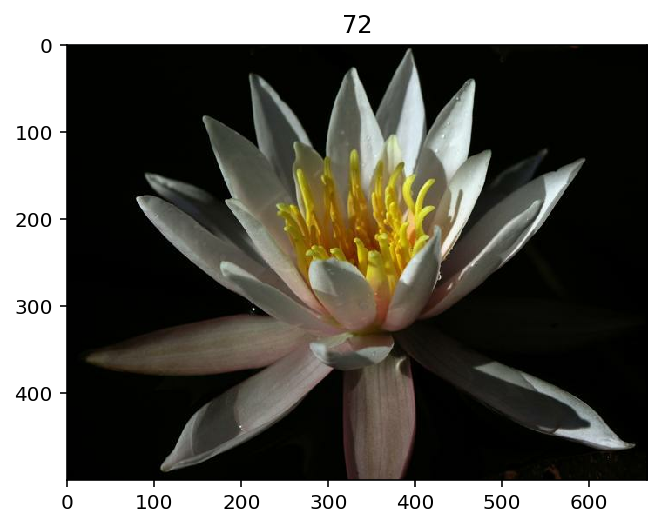

In [8]:
# from previous cell we saw that images have different sizes, we need to resize them all to the same shape to be
# able to train our model

#  Plot 1 image from the training set.
for image, label in training_set.take(1):
    image = image.numpy().squeeze()
    label = label.numpy()

# Set the title of the plot to the corresponding image label.
plt.imshow(image)
plt.title(label)
plt.show()

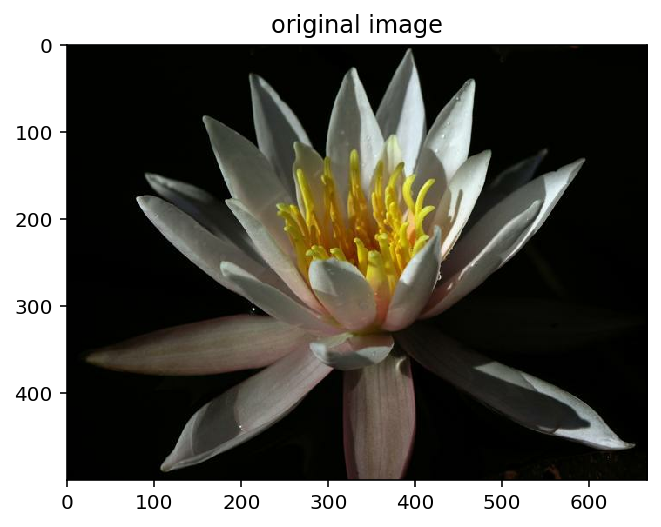

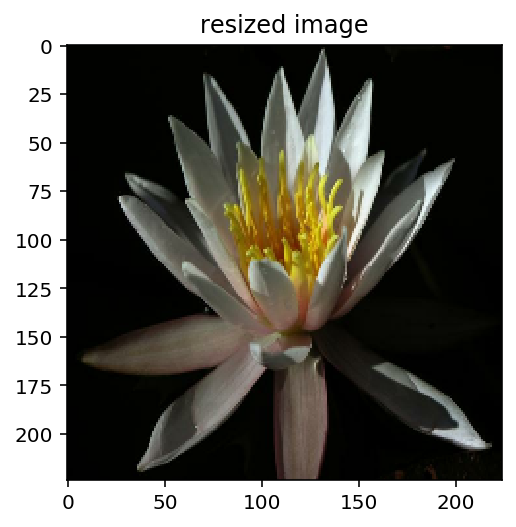

In [9]:
# check the effect of resizing

for img, label in training_set.take(1):
    plt.imshow(img.numpy().squeeze())
    plt.title("original image")
    plt.show()
    plt.imshow(tf.image.resize(img, (224,224)).numpy().squeeze()/255)
    plt.title("resized image")
    
    plt.show()

### Label Mapping

we'll also need to load in a mapping from label to category name. this can be found in the file `label_map.json`. It's a JSON object. This will give us a dictionary mapping the integer coded labels to the actual names of the flowers.

In [10]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

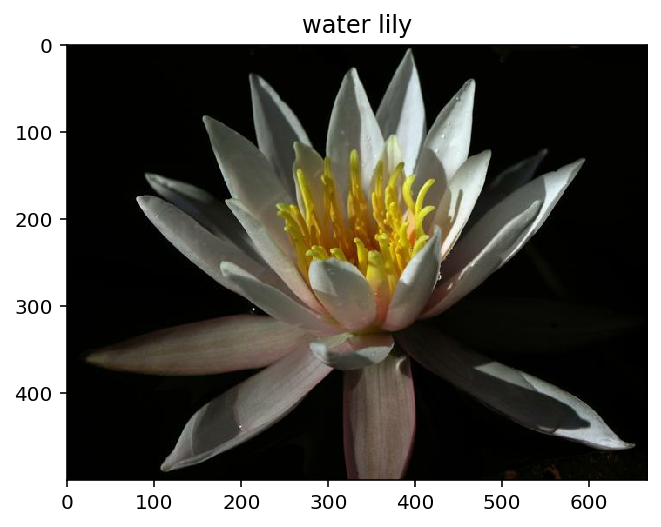

In [11]:
# Plot 1 image from the training set, with the title of the plot be the corresponding class name. 

# I added 1 to the label to get the right name from the .json, the correct label class is 72 from the website,
# but it sounds that all the classes labels are increased by 1 

plt.imshow(image)
plt.title(class_names[str(label.numpy()+1)])
plt.show()

## Create Pipeline

In [12]:
# Create a pipeline for each set.
batch_size = 64
image_size = 224
def normalize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (image_size,image_size))
    image /= 225
    return image, label


training_batches = training_set.shuffle(training_examples_num//4).map(normalize).batch(batch_size).prefetch(1)
validation_batches = training_set.map(normalize).batch(batch_size).prefetch(1)
testing_batches = training_set.map(normalize).batch(batch_size).prefetch(1)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. we will use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

In [13]:
# Build and train your network.

# getting the pretrained model MobileNet_V2
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pretrained = hub.KerasLayer(URL, input_shape = (image_size, image_size, 3))
pretrained.trainable = False


# building the full model
model = tf.keras.Sequential([
    pretrained,
    tf.keras.layers.Dense(num_classes, activation = 'softmax')
])

print(model.summary())


model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)


# training the model
epochs = 20
history = model.fit(training_batches,
             epochs = epochs,
             validation_data = validation_batches,
             callbacks = [early_stopping])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 102)               130662    
Total params: 2,388,646
Trainable params: 130,662
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/20
16/16 [==============================] - 56s 3s/step - loss: 4.8464 - accuracy: 0.0176 - val_loss: 3.4229 - val_accuracy: 0.3010
Epoch 2/20
16/16 [==============================] - 52s 3s/step - loss: 3.0826 - accuracy: 0.4181 - val_loss: 2.1430 - val_accuracy: 0.7608
Epoch 3/20
16/16 [==============================] - 52s 3s/step - loss: 1.8893 - accuracy: 0.8349 - val_loss: 1.3526 - val_accuracy: 0.8990
Epoch 4/20
16/16 [==============================] - 52s 3s/step - loss: 1.209

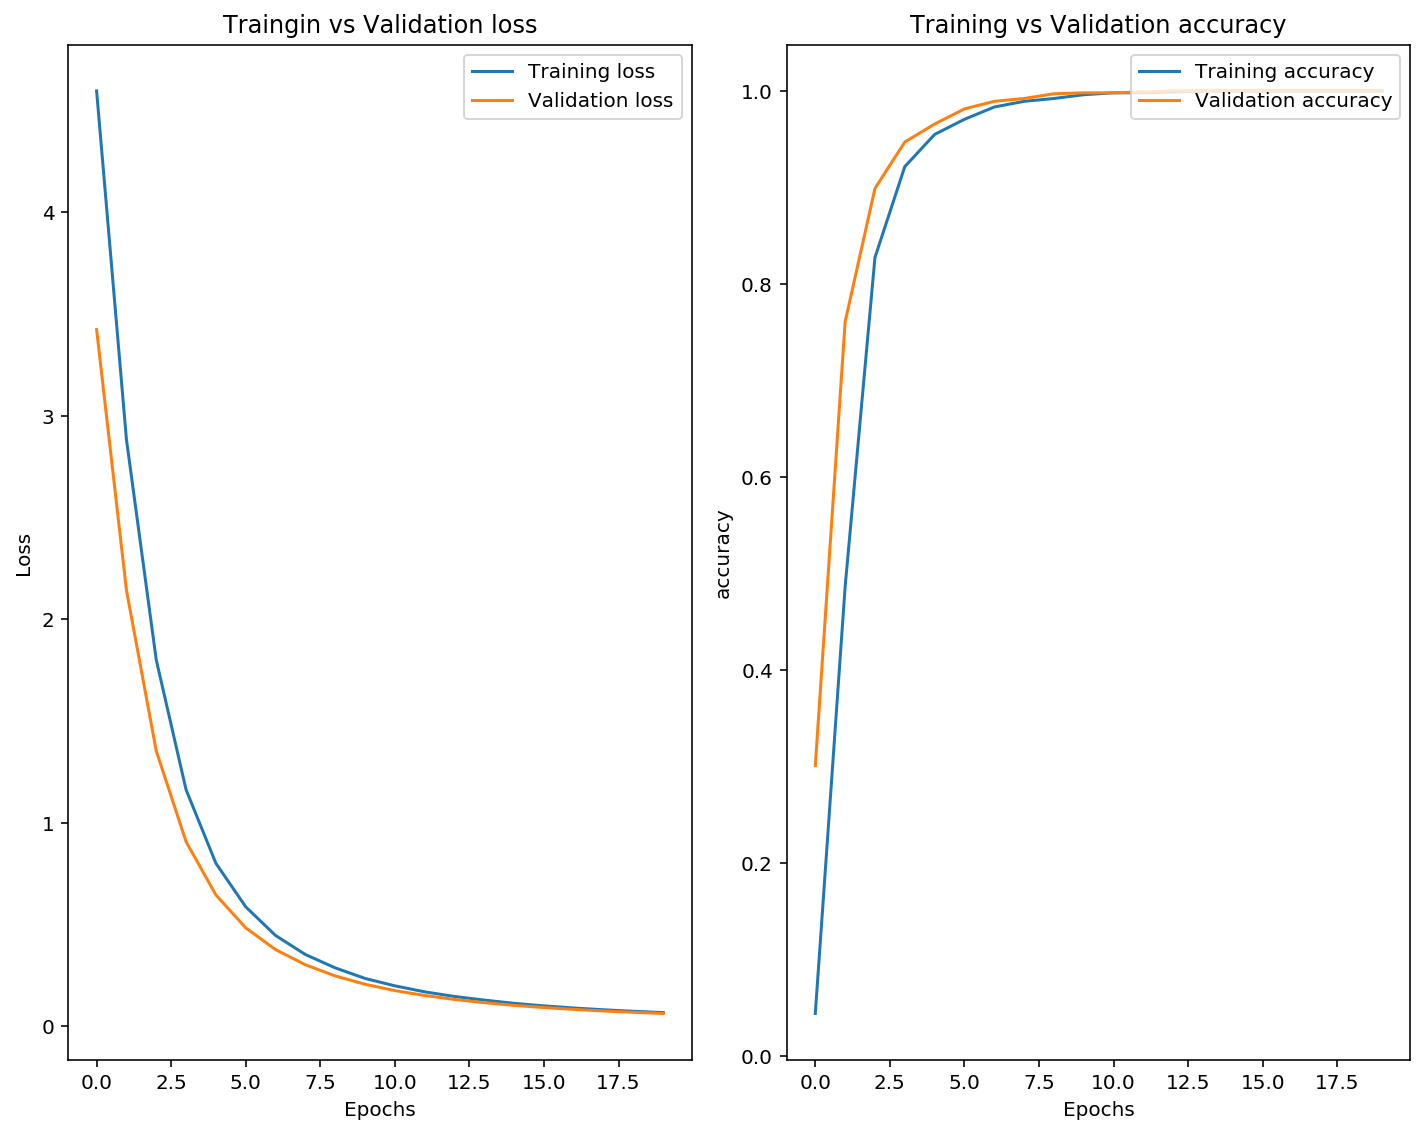

In [14]:
# Plot the loss and accuracy values achieved during training for the training and validation set.
xticks = range(epochs)
fig, (ax1,ax2) = plt.subplots(figsize=(10,8), ncols=2)

ax1.plot(history.history['loss'], label='Training loss')
ax1.plot(history.history['val_loss'], label = 'Validation loss')
ax1.set_title("Traingin vs Validation loss")
ax1.set_xticks(xticks)
ax1.set_ylabel("Loss")
ax1.set_xlabel("Epochs")
ax1.legend(loc='upper right')

ax2.plot(history.history['accuracy'], label='Training accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation accuracy')
ax2.set_title("Training vs Validation accuracy")
ax2.set_xticks(xticks)
ax2.set_ylabel("accuracy")
ax2.set_xlabel("Epochs")

ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images.

In [15]:
# Print the loss and accuracy values achieved on the entire test set.
loss, accuracy = test_predictions = model.evaluate(testing_batches)

print("Loss on the Test dataset is: ", loss)
print("Model accuracy on the Test dataset is: ", accuracy) 

16/16 [==============================] - 25s 2s/step - loss: 0.0627 - accuracy: 1.0000
Loss on the Test dataset is:  0.06269532442092896
Model accuracy on the Test dataset is:  1.0


## Save the Model

Now that our network is trained, we should consider saving the model so we can load it later for making inference and in our application without training it again.

In [16]:
# Save the trained model as a Keras model.
model.save('./tested_model_HDF5.h5')


## Load the Keras Model


In [17]:
# Load the Keras model
loaded_model = tf.keras.models.load_model('./tested_model_HDF5.h5',\
                    custom_objects={'KerasLayer':hub.KerasLayer},compile=False)

# Inference for Classification

### Pre-processing Images

In [18]:
# The process_image function
def process_image(image):
    '''
    Inputs: Image (numpy array)
    
    Returns: processed image as a numpy array with shape (224,224,3) as the model expects
    '''
    tensor_image = tf.convert_to_tensor(image)
    resized_image = tf.image.resize(tensor_image, (224,224))/255
    return resized_image.numpy()


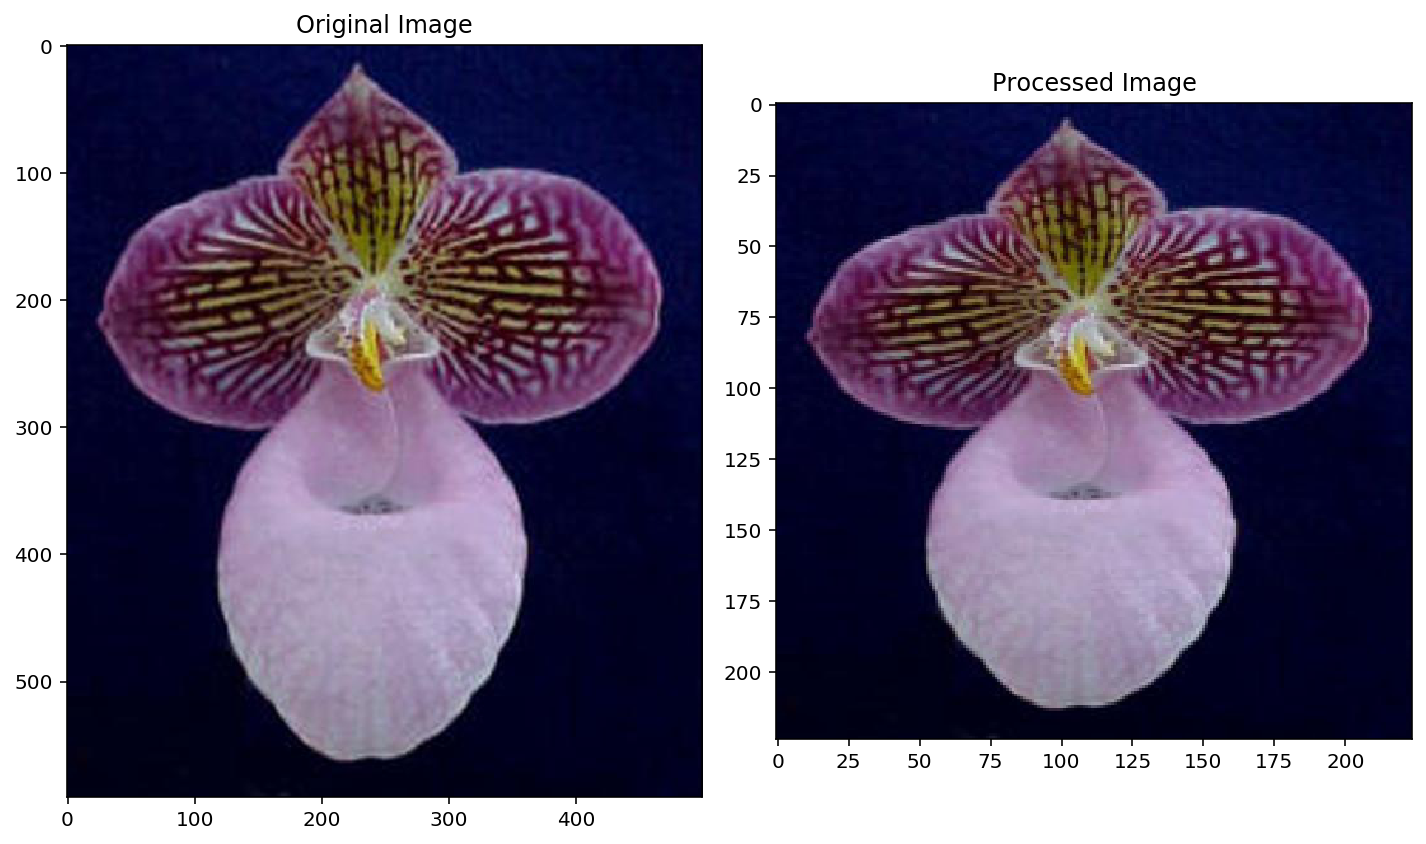

In [19]:
# Check the process_image

from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

### Inference

In [20]:
# The predict function
def predict(image, model, top_k):
    '''
    Inputs: image with shape(224,224,3)
    
    Returns: K most likely class labels along with the probabilities
    '''
    probs = model.predict(image)[0]
    
    #rounding the probabilities
    probs = [round(probability, 5) for probability in probs]
    # get top k class labels
    classes_indecies = [ str(ind+1) for ind in np.argsort(probs)[-top_k:]]
    return probs[np.argsort(probs)[-top_k:]], classes_indecies

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check our predictions we will use 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

<img src='inference_example.png' width=600px>


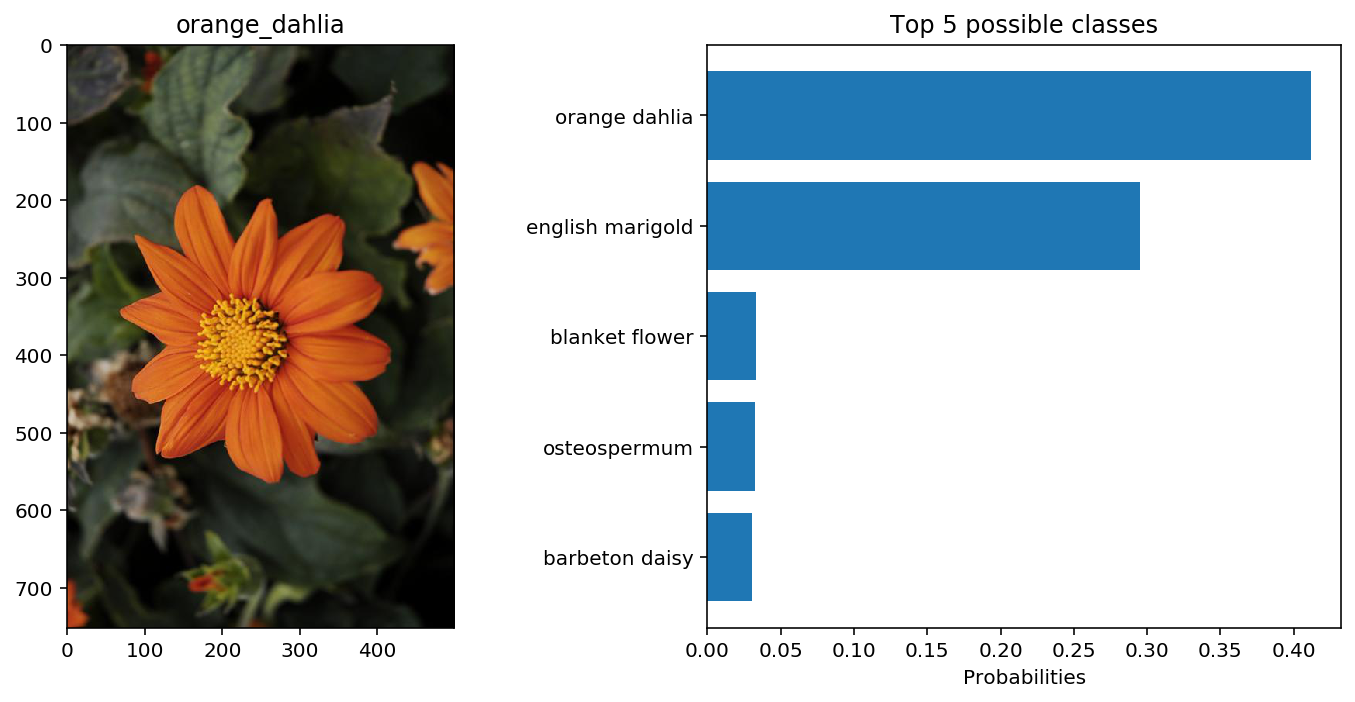

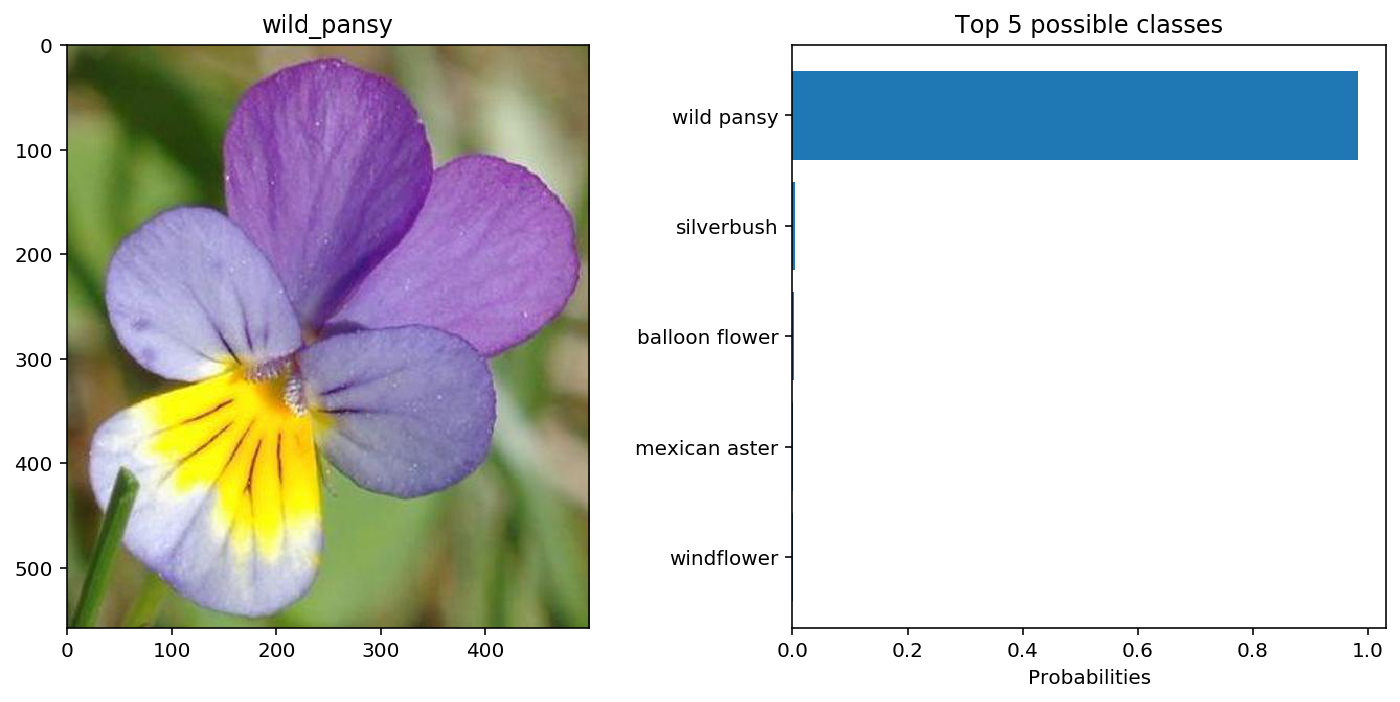

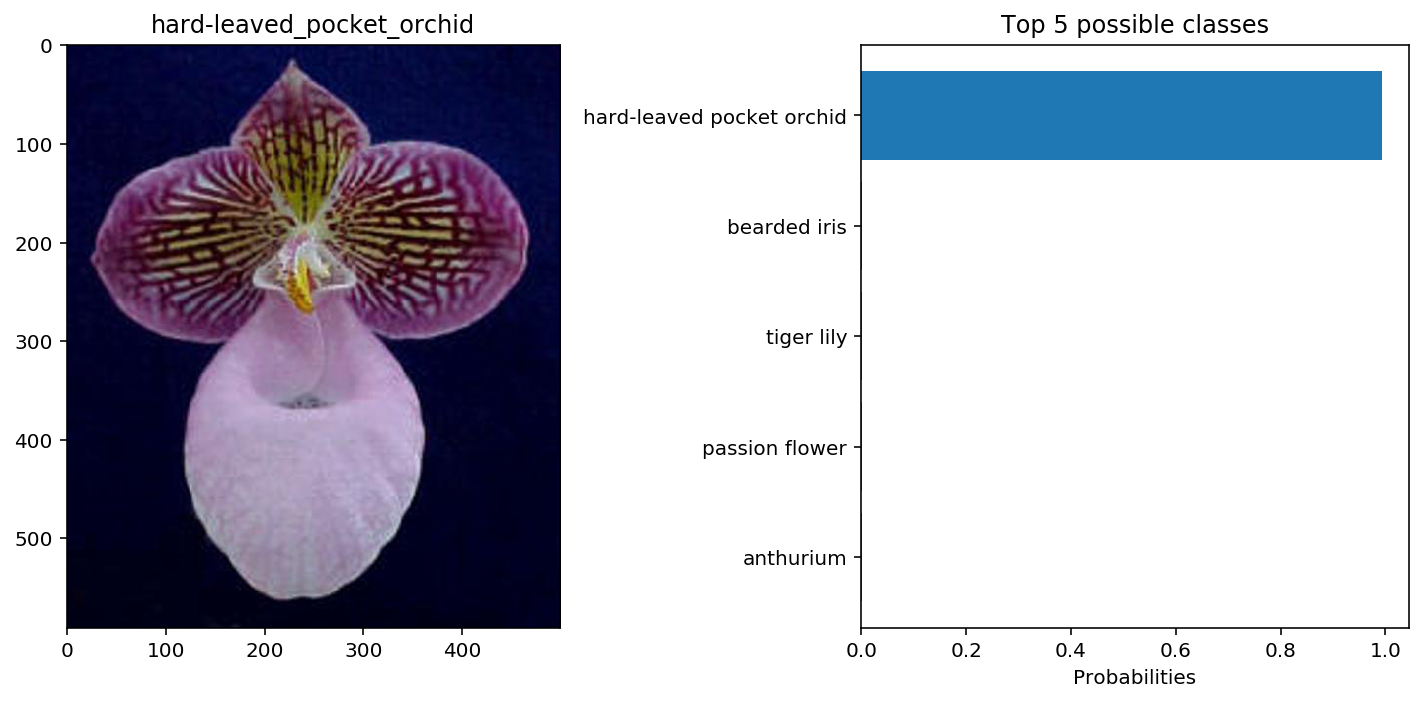

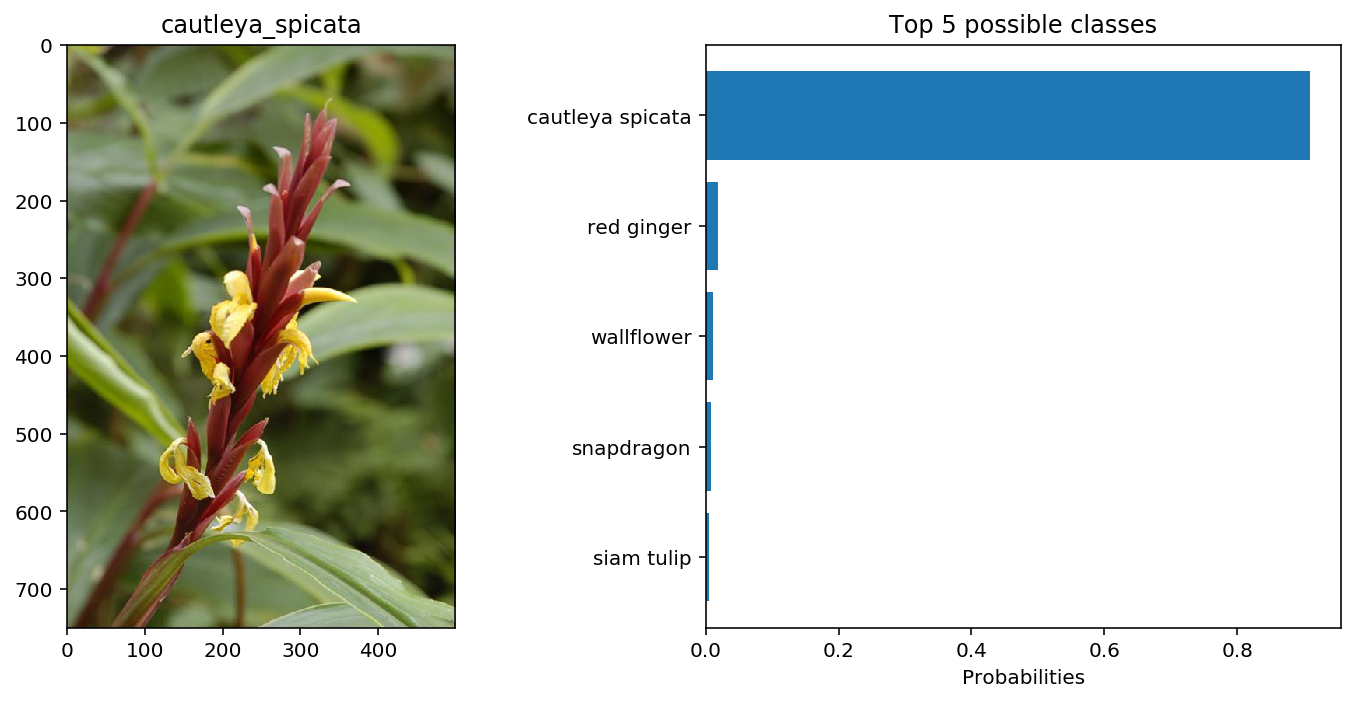

In [21]:
# Plot the input image along with the top 5 classes
import os

for image_file in os.listdir("./test_images"):
    fig, (ax1, ax2) = plt.subplots(figsize=(10,5), ncols=2)
    image = Image.open("./test_images/"+image_file)
    ax1.imshow(image)
    ax1.set_title(image_file.split(".")[0])
    
    test_image = np.asarray(image)

    processed_test_image = np.expand_dims(process_image(test_image), axis = 0)
    probs,classes = predict(processed_test_image, loaded_model, 5)

    yticks = np.array([1,2,3,4,5])
    ax2.barh(yticks, probs, align = 'center')
    ax2.set_yticks(yticks)
    labels = [class_names[hashed] for hashed in classes]
    ax2.set_yticklabels(labels)
    ax2.set_title("Top 5 possible classes")
    ax2.set_xlabel("Probabilities")
    plt.tight_layout()
    plt.show()